scoring heat map
iou vs 

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pickle
from scipy.misc import imresize, imread, imsave
from inference import forward_pass
from scipy.misc import imresize
import matplotlib.pyplot as plt
import subprocess
import os


In [2]:
def coco_API_plot(origin_img, diff_objects):
    np.save("/home/fred/tmp/lua_bridge.npy", diff_objects)
    imsave("/home/fred/tmp/lua_bridge.jpg", (origin_img/2).astype(np.uint8))
    bashCommand = "cd /home/fred/Desktop/bot_mask_tool && th generated_msked_im.lua -img /home/fred/tmp//lua_bridge.jpg -masks /home/fred/tmp/lua_bridge.npy"
    subprocess.call(['/bin/bash', '-i', '-c', bashCommand])
    coco_style_plt_mask = imread("/home/fred/Desktop/bot_mask_tool/test.jpg")
#     coco_style_plt_mask = imresize(coco_style_plt_mask, (240,240))
    return coco_style_plt_mask

In [3]:
def load_data(img_path, mask_path):
    
    
    img_items = sorted([img_path + '/'+ item for item in os.listdir(img_path)])
    mask_items = sorted([mask_path + '/'+ item for item in os.listdir(mask_path)])
    imgs = np.zeros((len(img_items), 350, 430, 3))
    masks = np.zeros((len(img_items), 350, 430))
    for i, img_name in enumerate(img_items):
        key = img_name.split('.jpg')[0].split('/')[-1]
        imgs[i] = imread(img_name)[20:370,230:660,:]
        #also prepare data for deepmask
        dp_mask_img = imread(img_name)[20:370,230:660,:]
        imsave("/home/fred/tmp/lua_dpm_bridge{}.jpg".format(i), dp_mask_img)
        mask_names = list(filter(lambda s: '/'+key+'_mask' in s, mask_items))
        for j, mask_name in enumerate(mask_names):
            mask = (imread(mask_name).sum(axis=2) > 0).astype(np.uint8)[20:370,230:660]
            masks[i] = np.logical_or(masks[i], mask)
        
    return imgs.astype(np.uint8), masks
imgs, masks = load_data(
#     '/home/fred/Desktop/bot_mask_tool/diff_bg/validation_unseen/Images/users/fred960315/unseen_bk_unseen_obj/',
#     '/home/fred/Desktop/bot_mask_tool/diff_bg/validation_unseen/Masks/users/fred960315/unseen_bk_unseen_obj/'
    '/media/4tb/dian/validation/Images/users/fred960315/validation',
    '/media/4tb/dian/validation/Masks/users/fred960315/validation'
)
# deep_mask_imgs, deep_mask_masks = deepmask_results(len(imgs))  

import pickle
# save_dict = {"msk":deep_mask_masks, "imgs": deep_mask_imgs}
# with open('/media/4tb/dian/validation/Masks/users/fred960315/deep_msk_npy.npy', 'wb') as handle:
#     pickle.dump(save_dict,handle, pickle.HIGHEST_PROTOCOL)
with open('/media/4tb/dian/validation/Masks/users/fred960315/deep_msk_npy.npy', 'rb') as handle:
    data = pickle.load(handle)
    deep_mask_imgs, deep_mask_masks = data['imgs'], data['msk']
from inference import forward_pass
reference = forward_pass("./models/11_3_morning/train_sgd_resnet18_lambda_24.00_a_23_b_46_decay_0.00500_lr_factor1.00_msk_ration24-193000", \
                         'resnet18',debug = True)

def iou(msk1, msk2):
    if np.sum(np.logical_or(msk1, msk2)) == 0:
        return 1000
    return np.sum(np.logical_and(msk1, msk2))/np.sum(np.logical_or(msk1, msk2))

def iou_help(total_msk, NMS_out):
    total_msk = np.lib.pad(total_msk, ([100,100],[100,100]), 'constant', constant_values=0)
    
    result = np.zeros_like(total_msk)
    for padded_msk in NMS_out:
        result = np.logical_or(padded_msk, result)
    return iou(result, total_msk)

finish building original graph


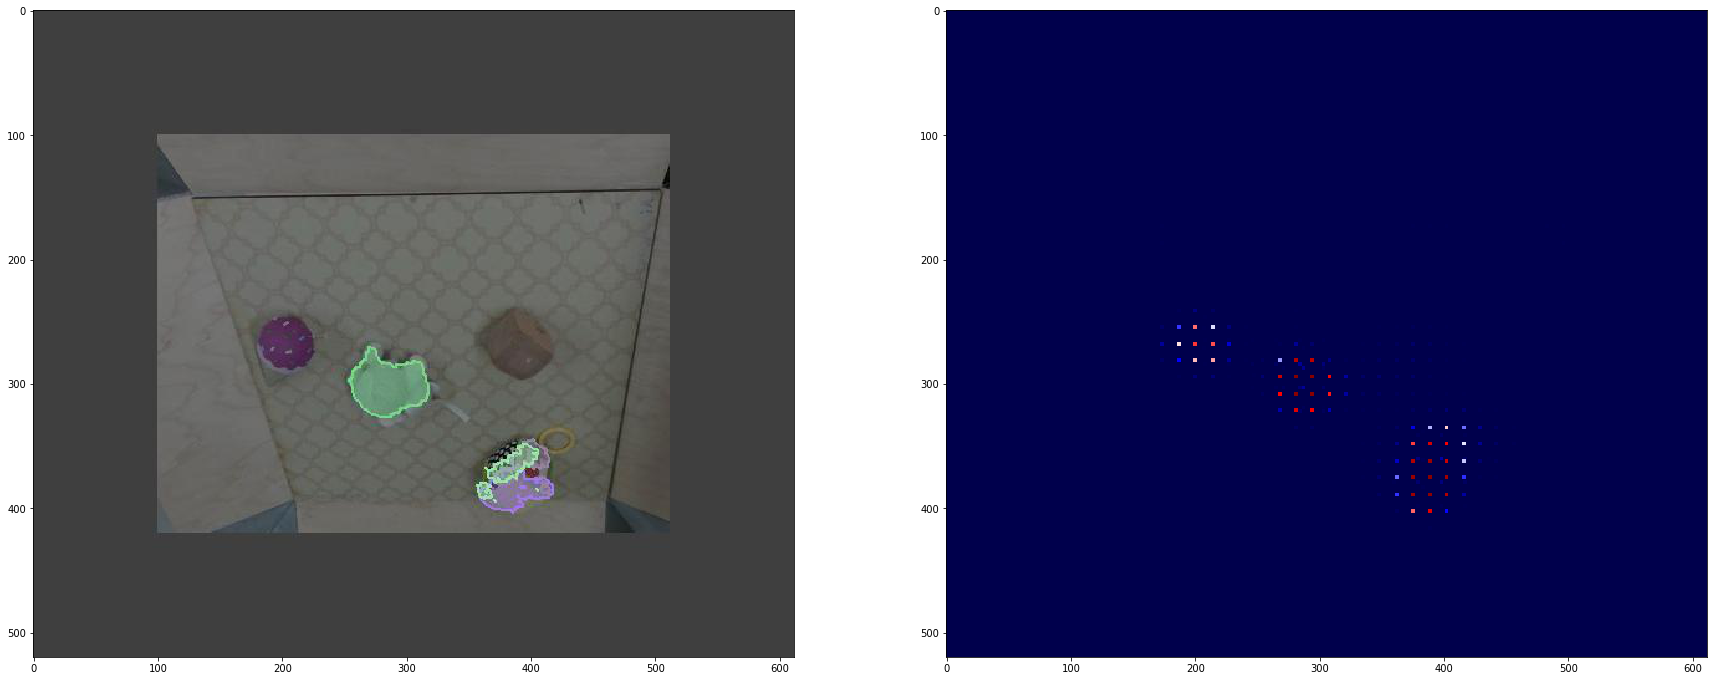

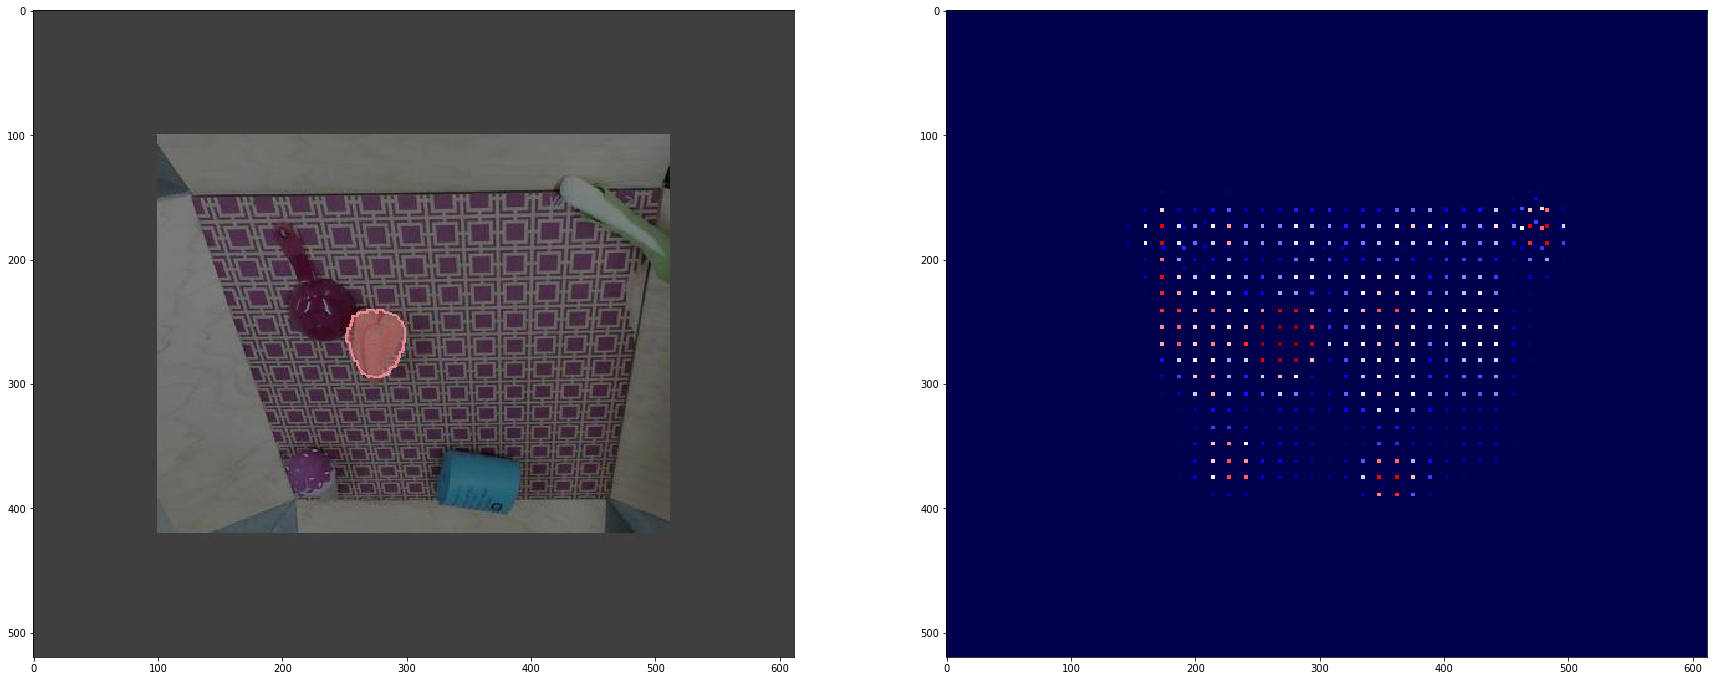

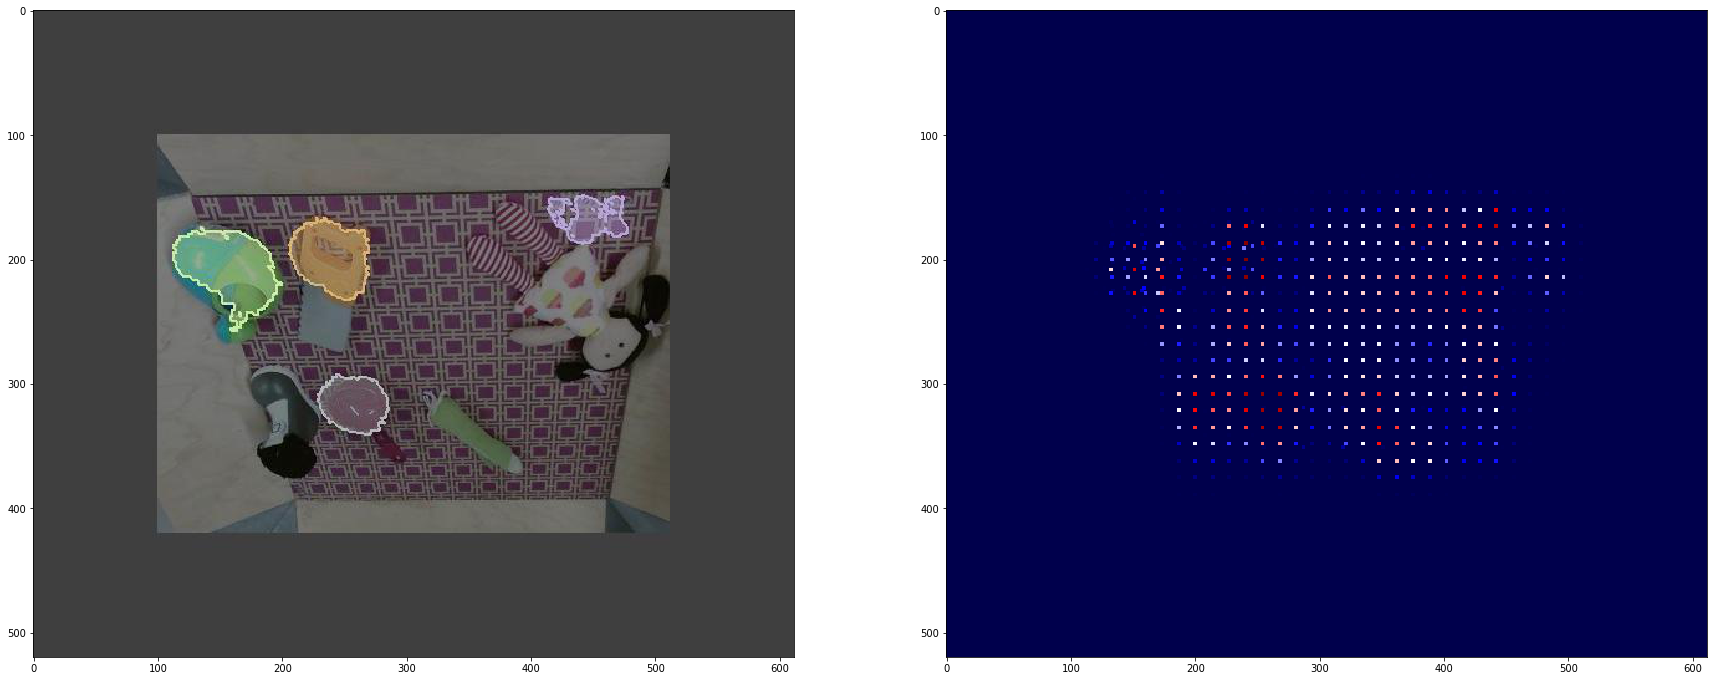

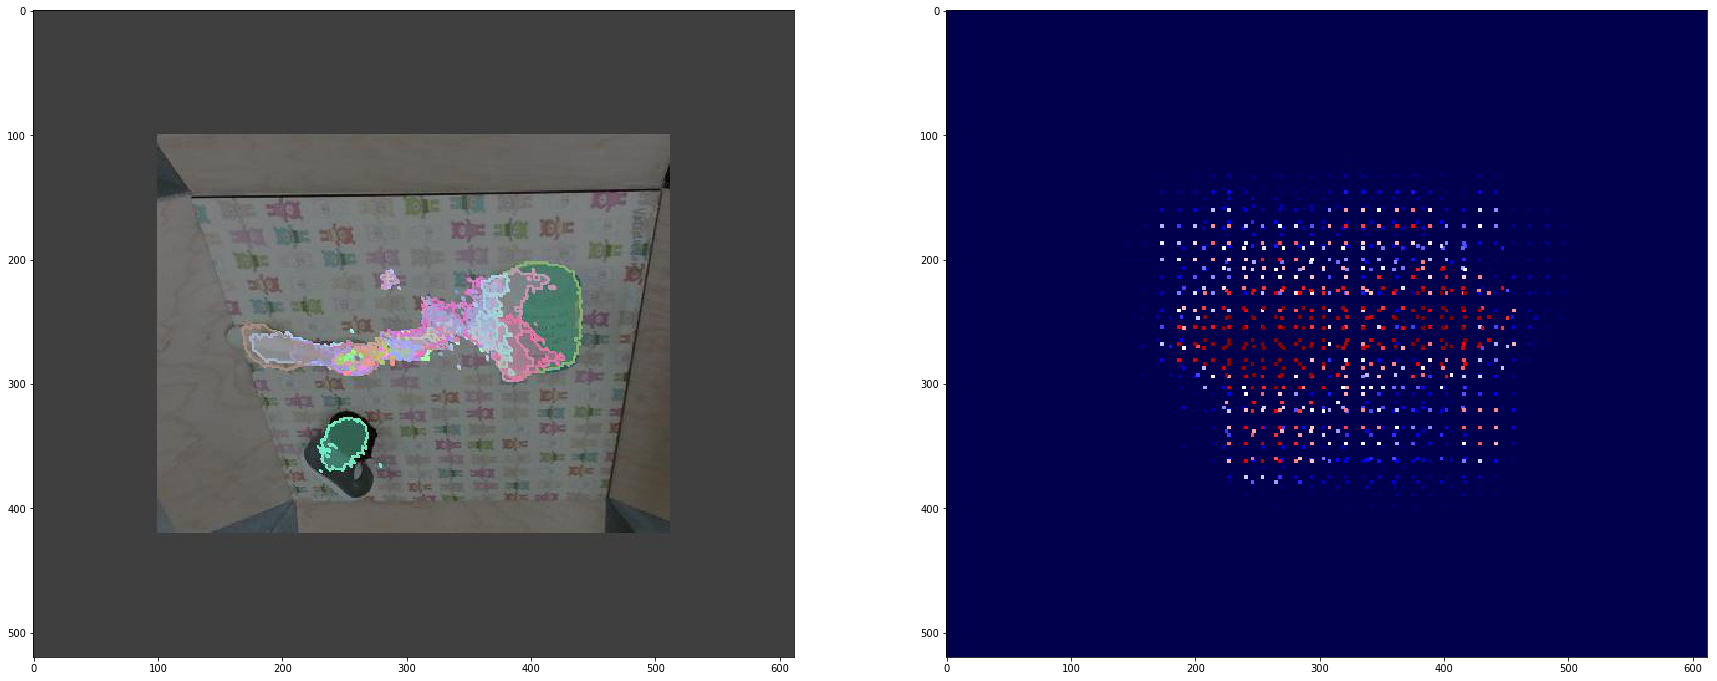

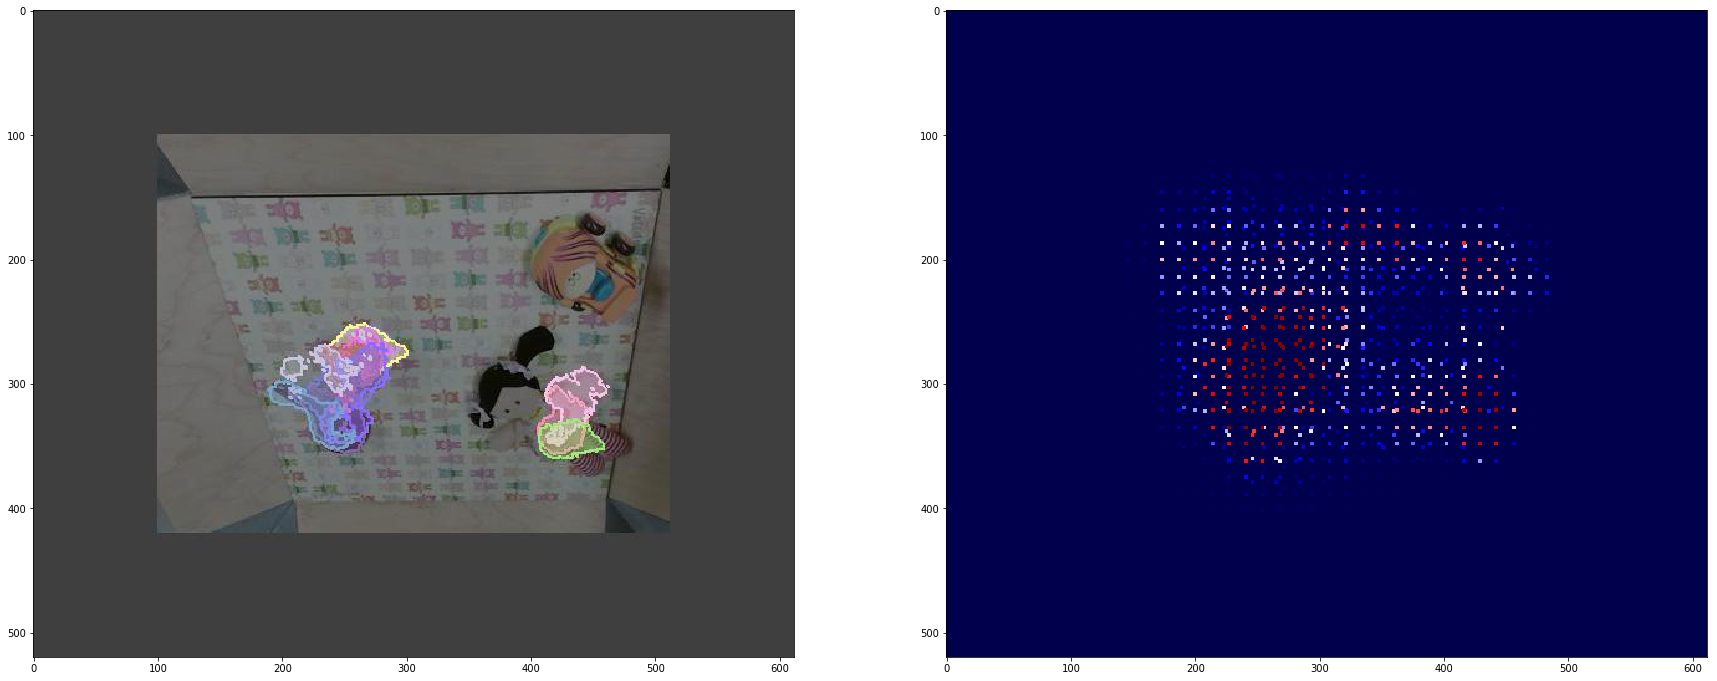

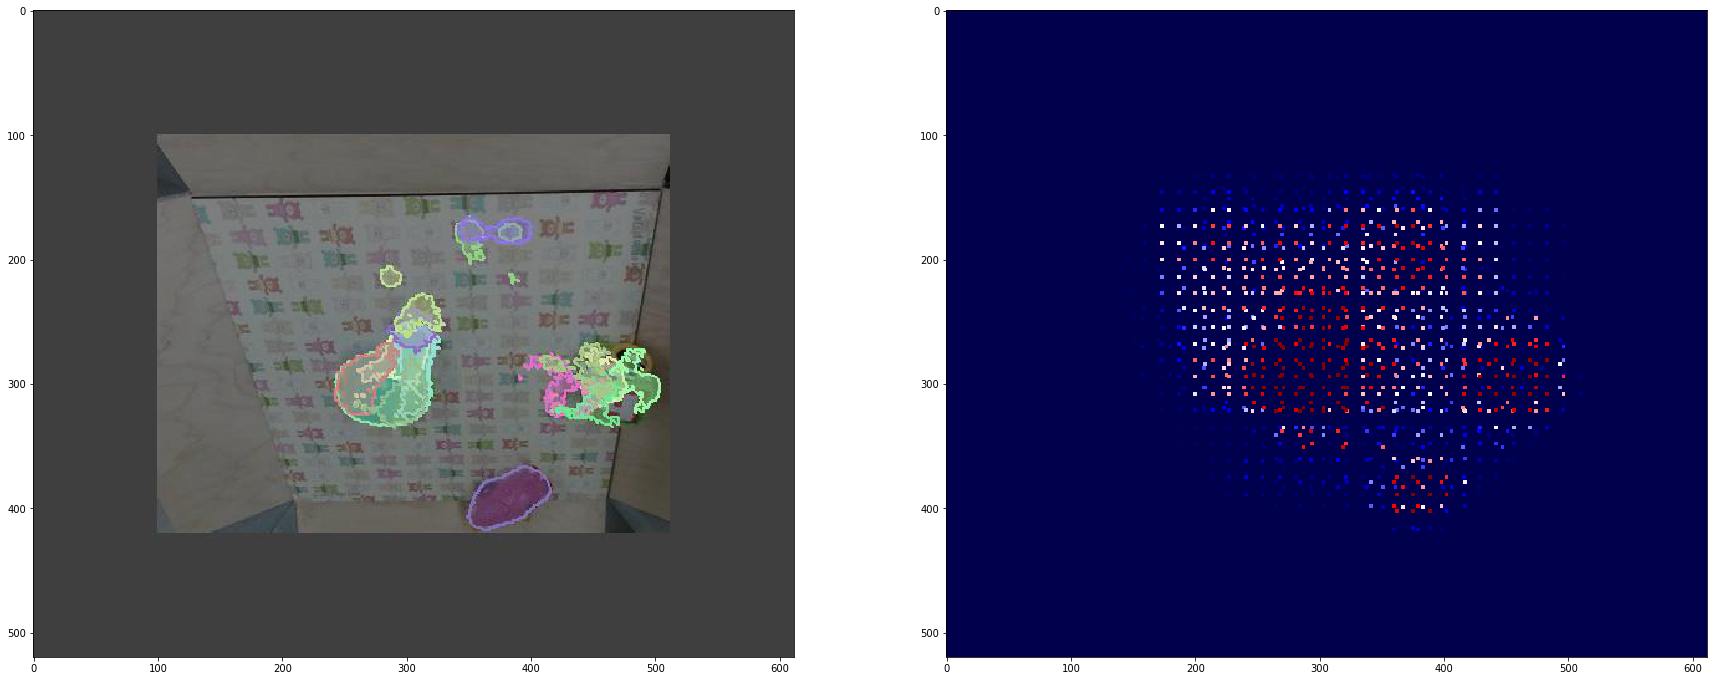

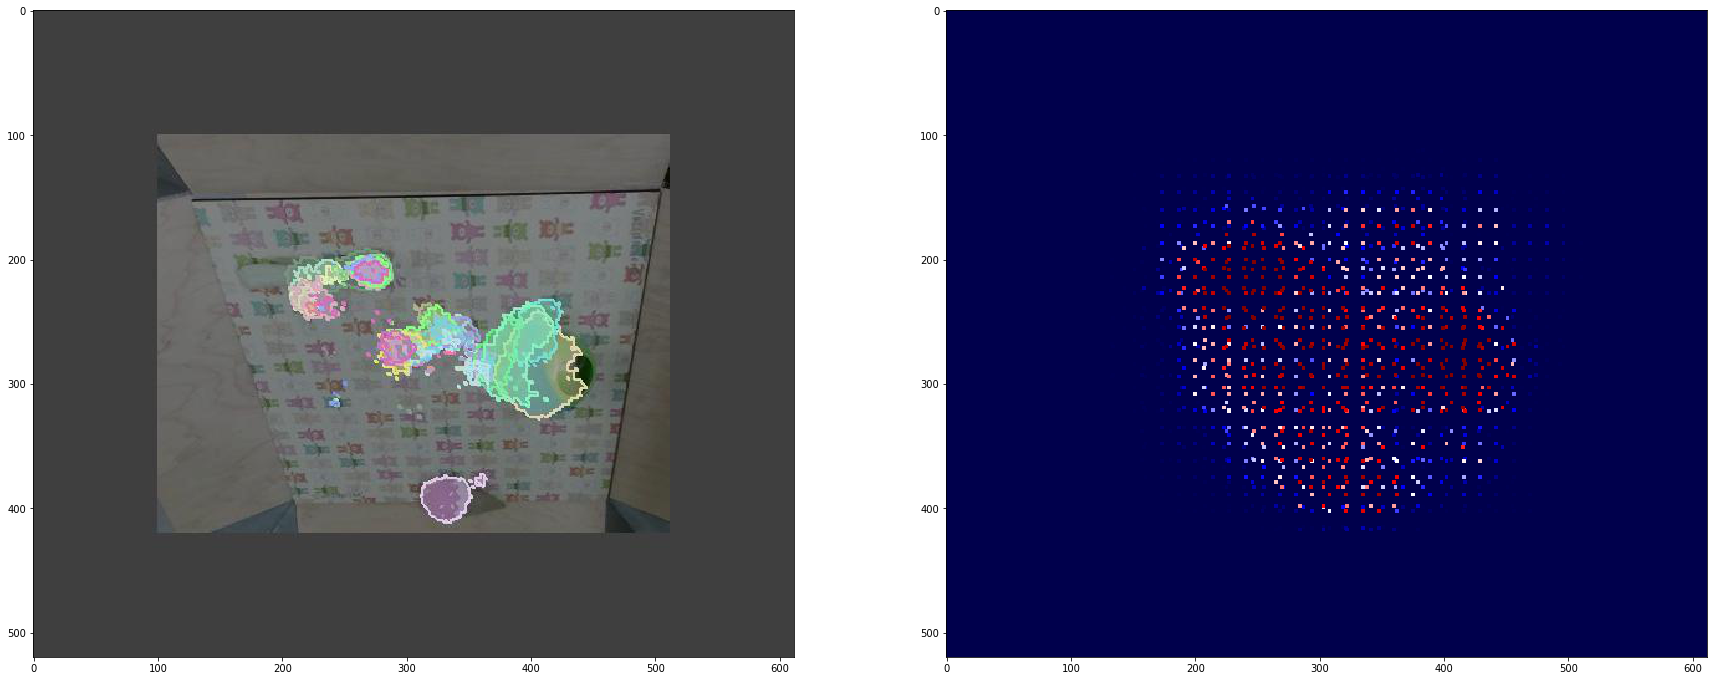

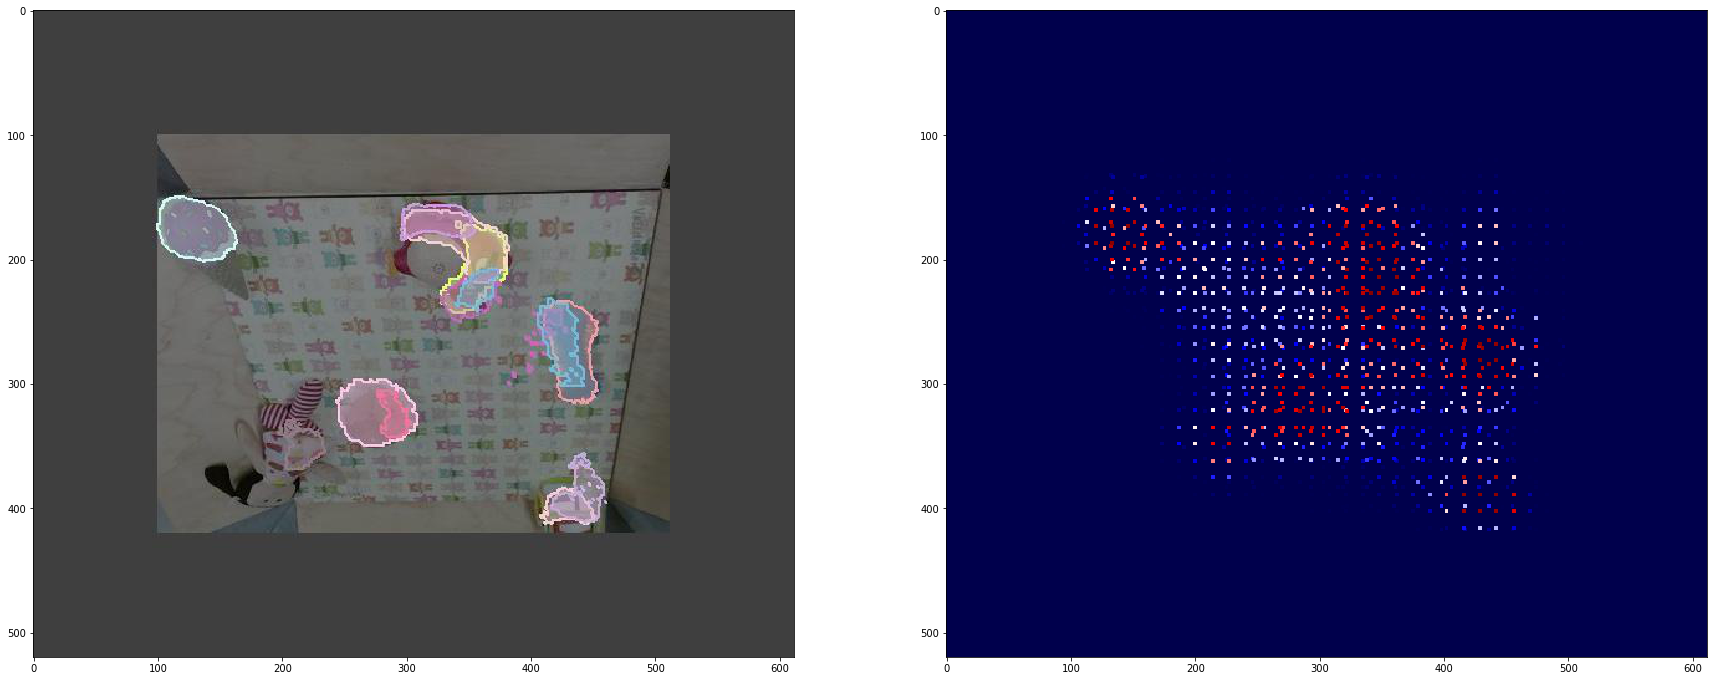

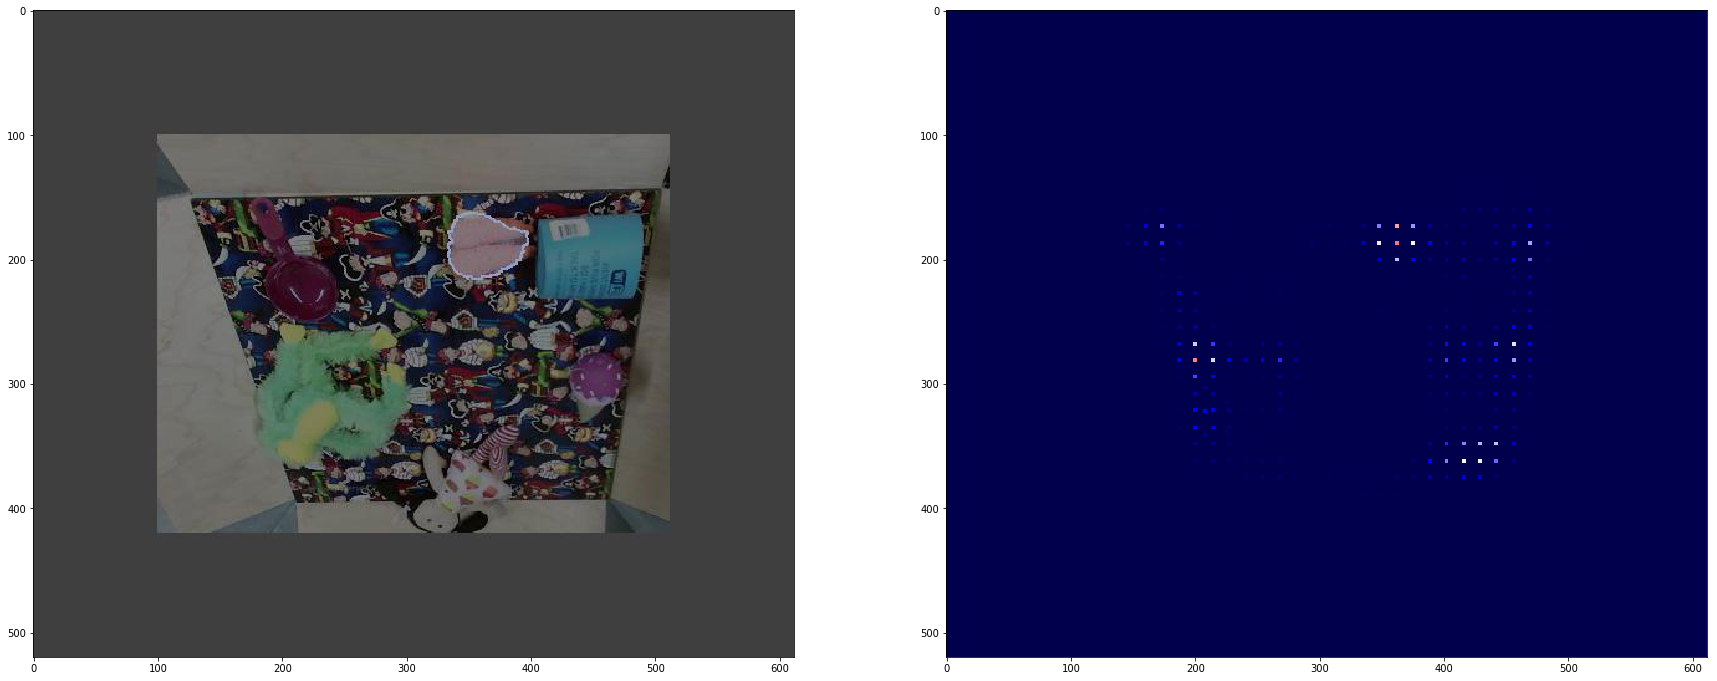

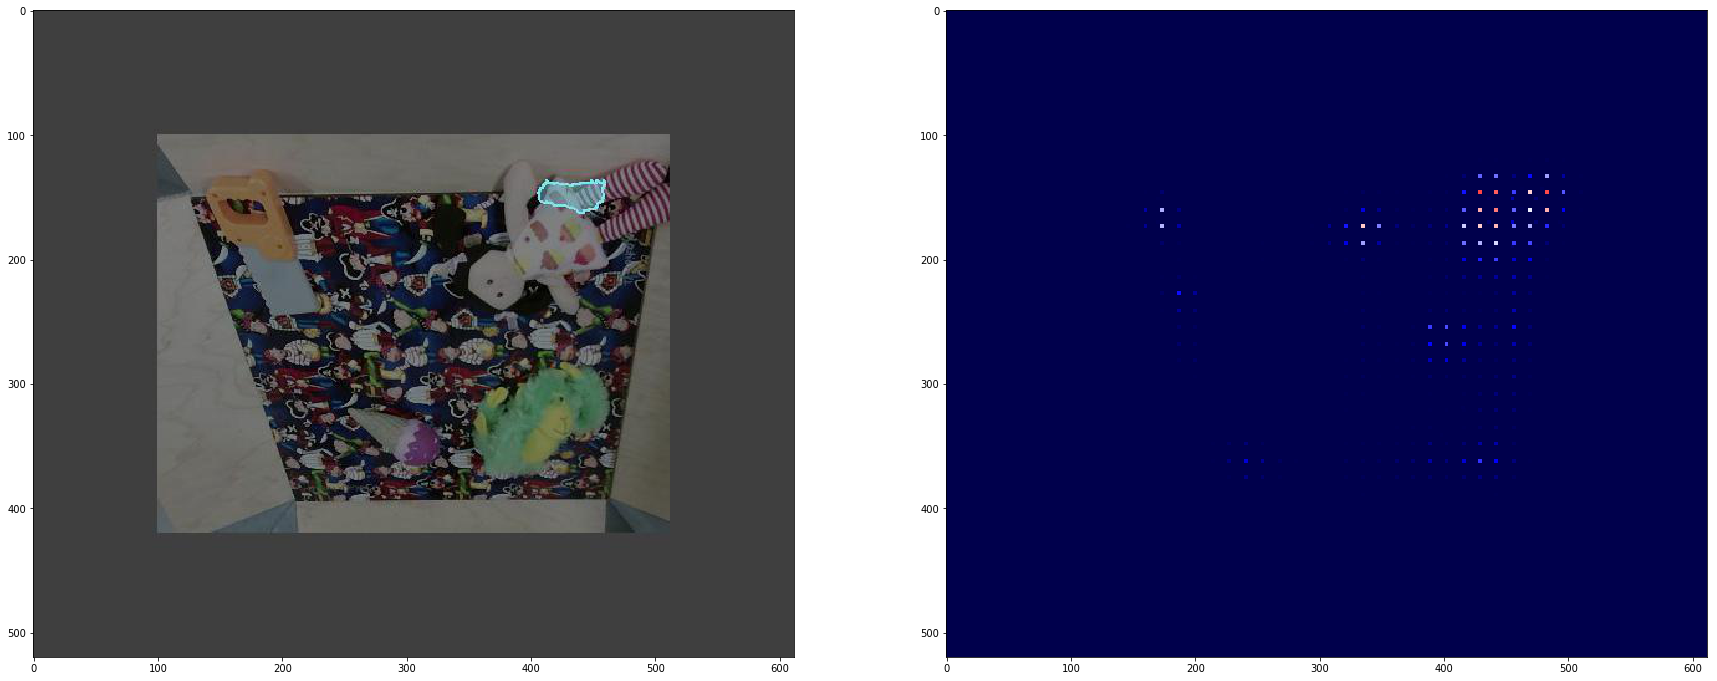

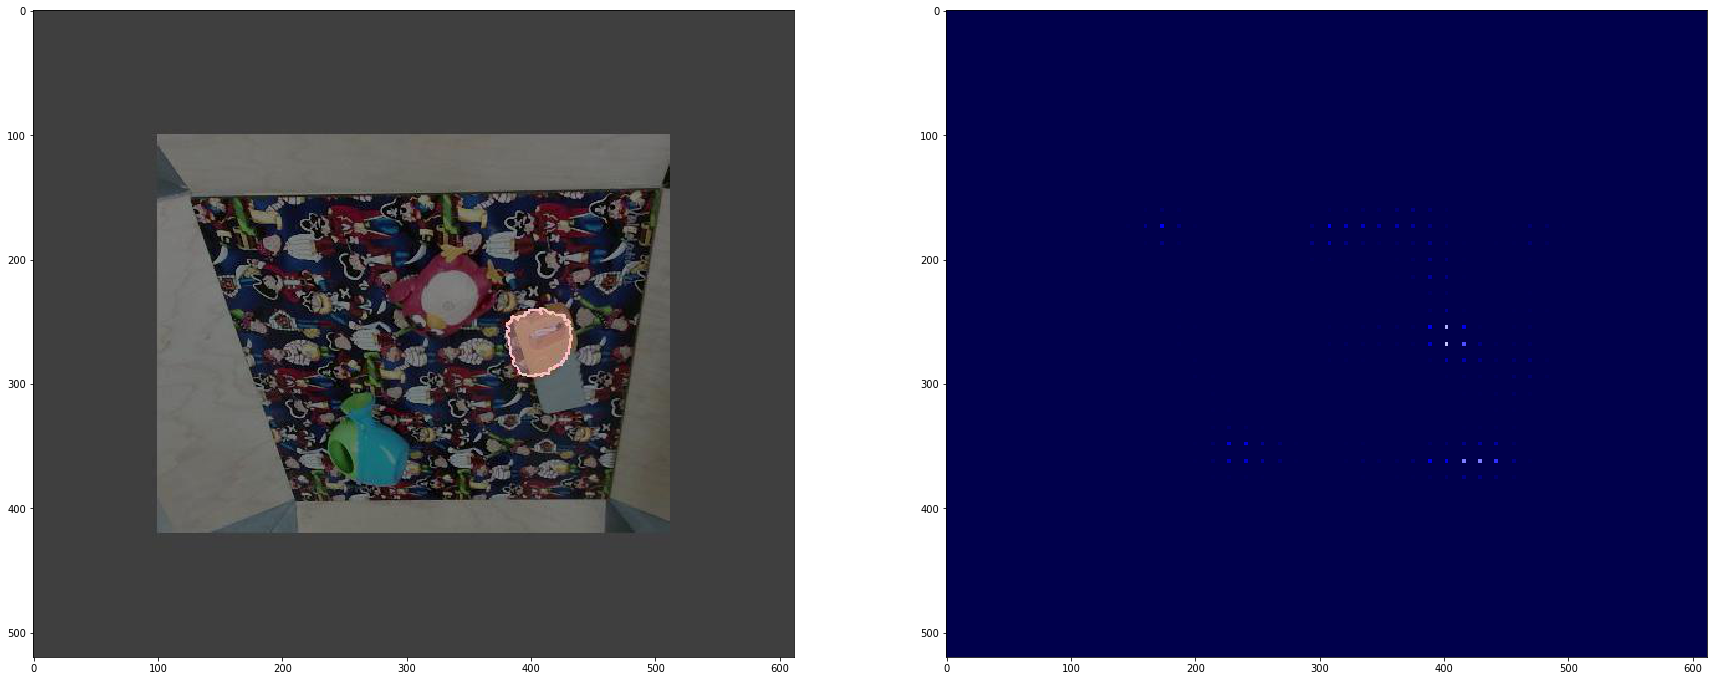

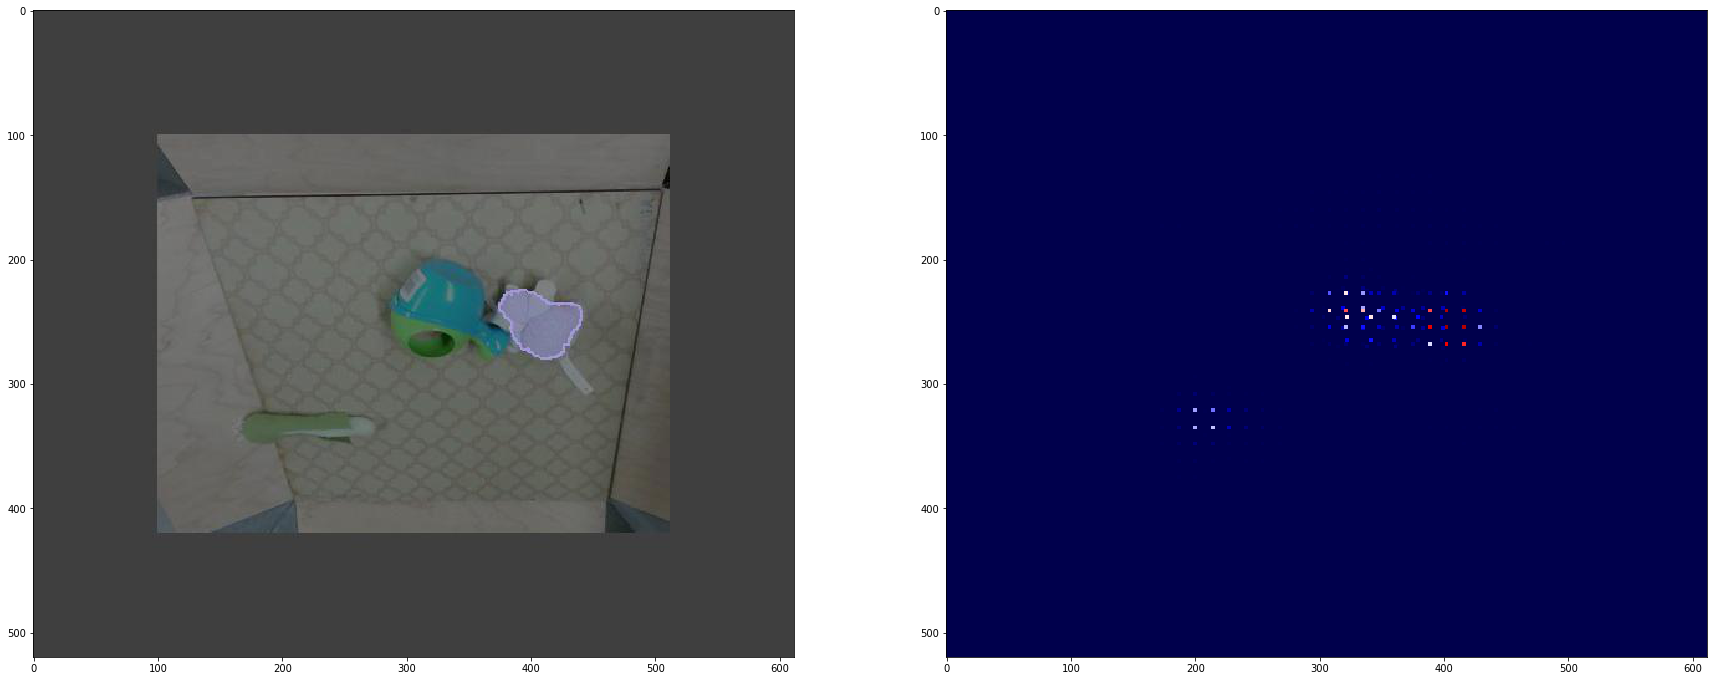

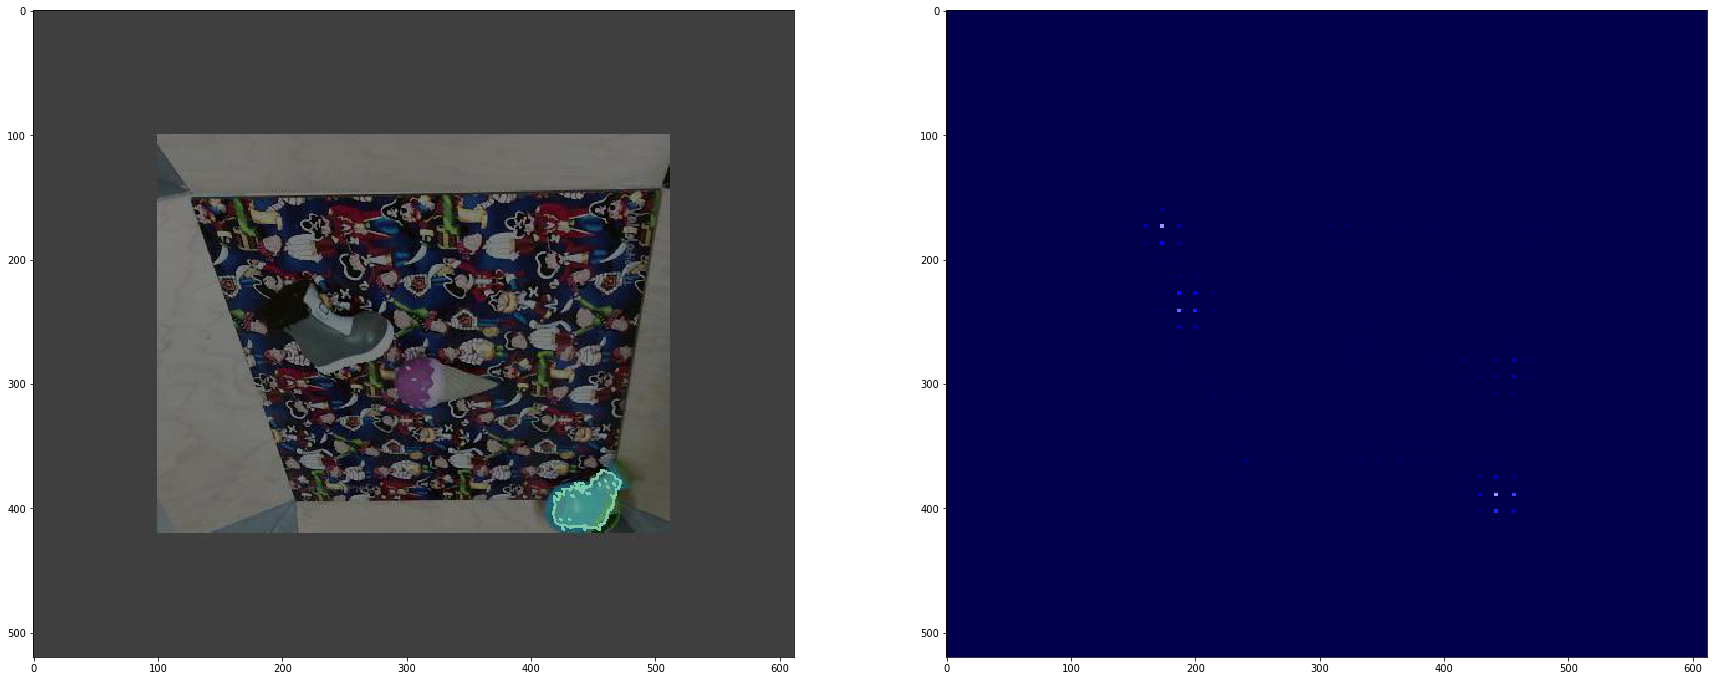

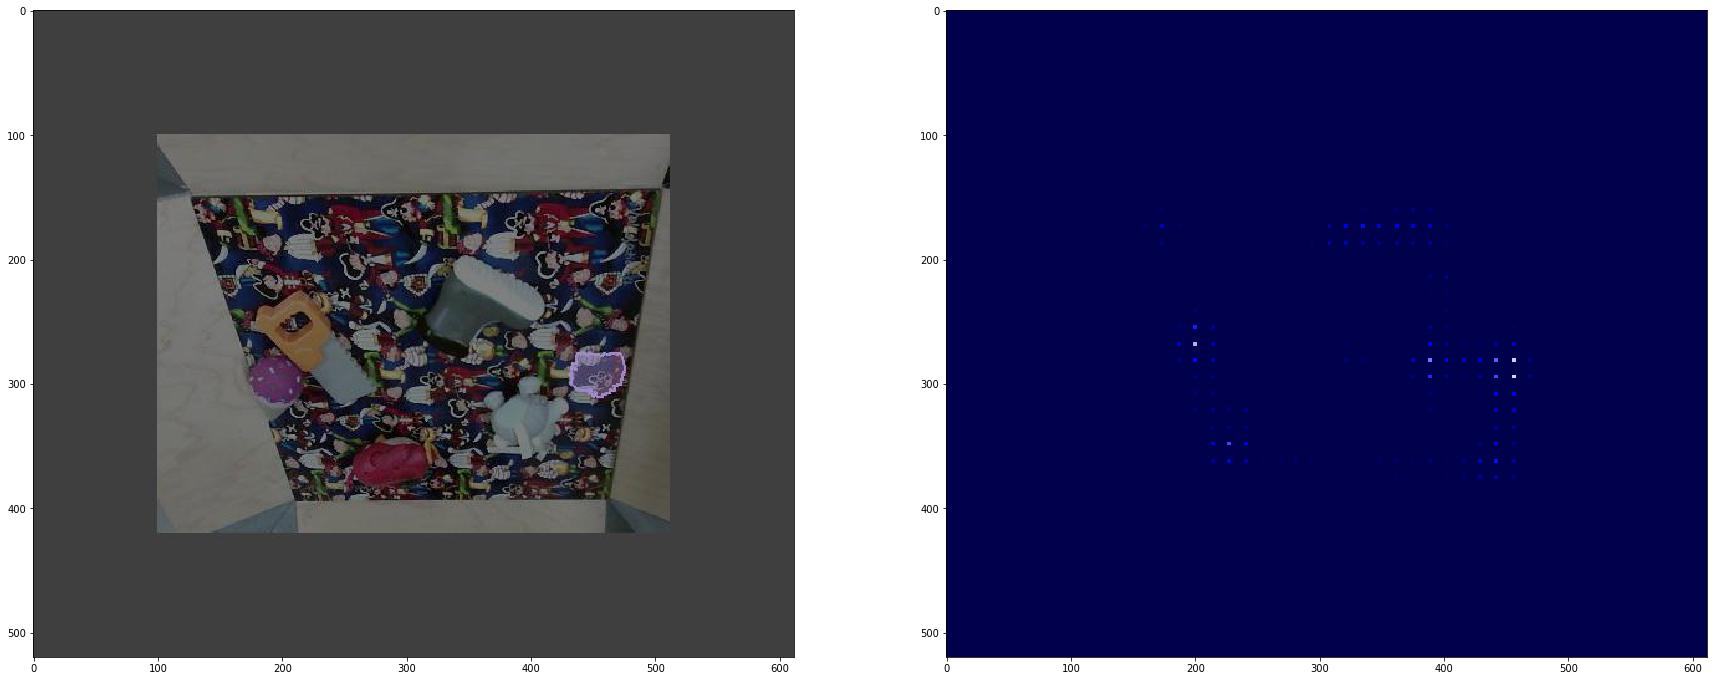

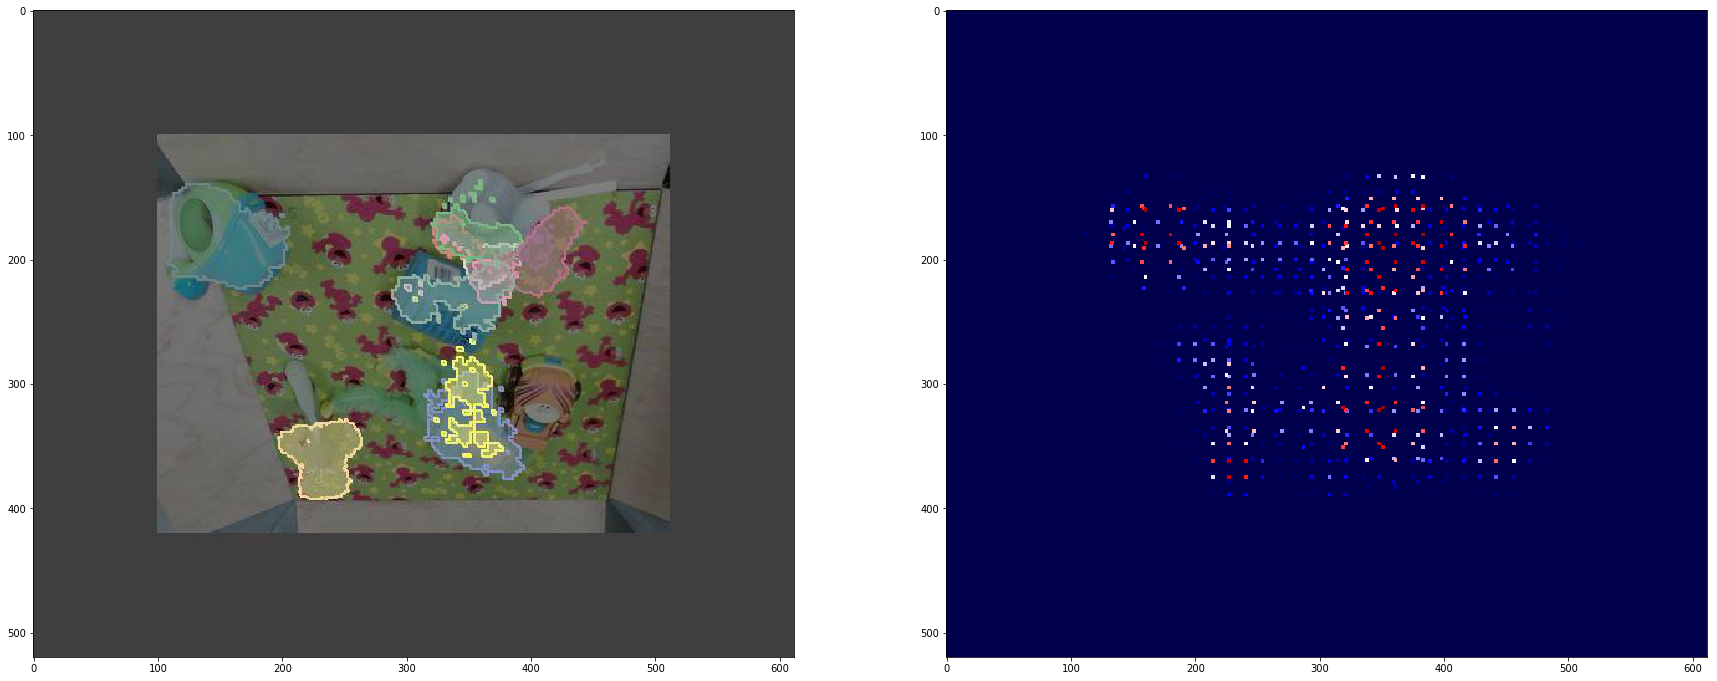

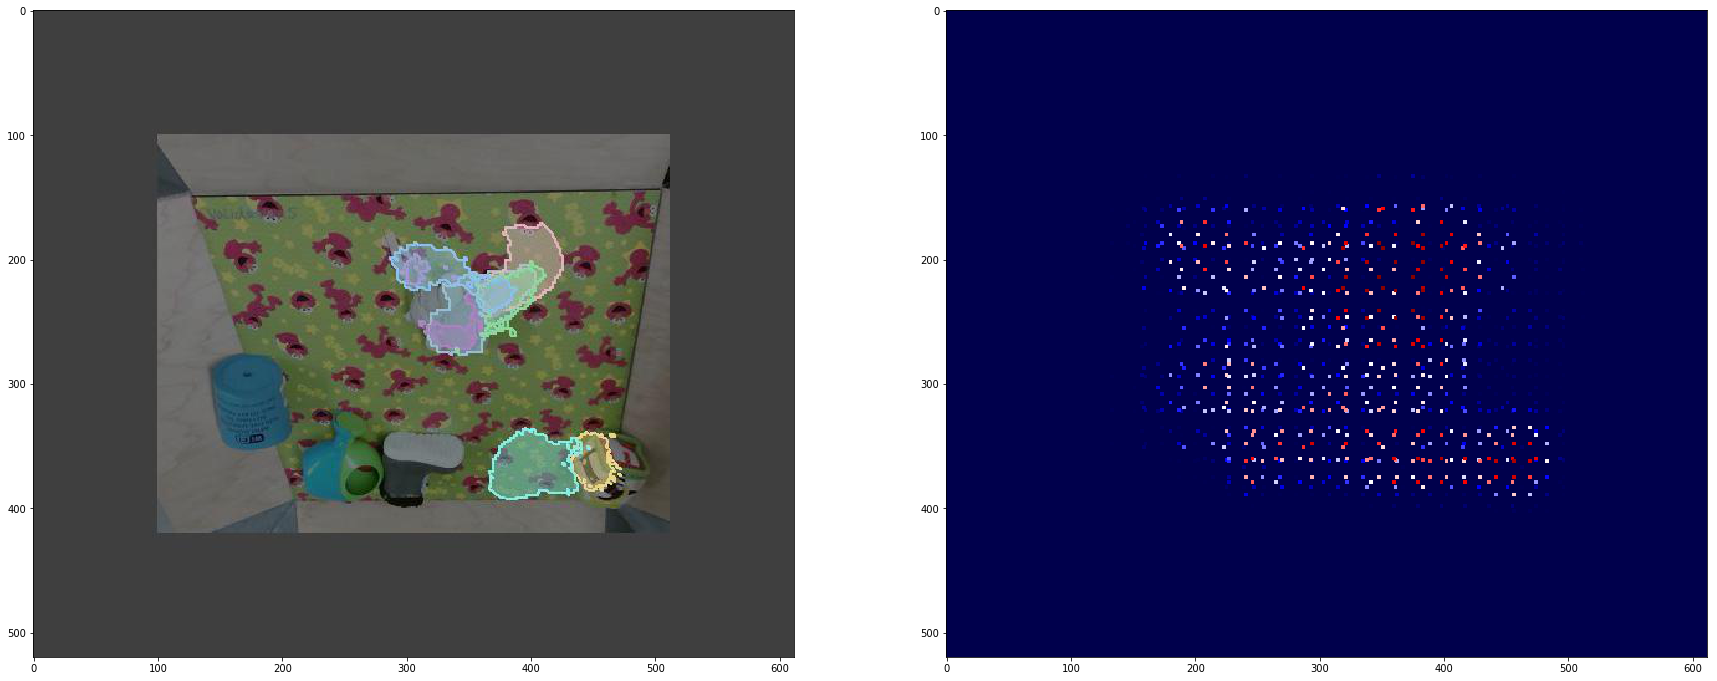

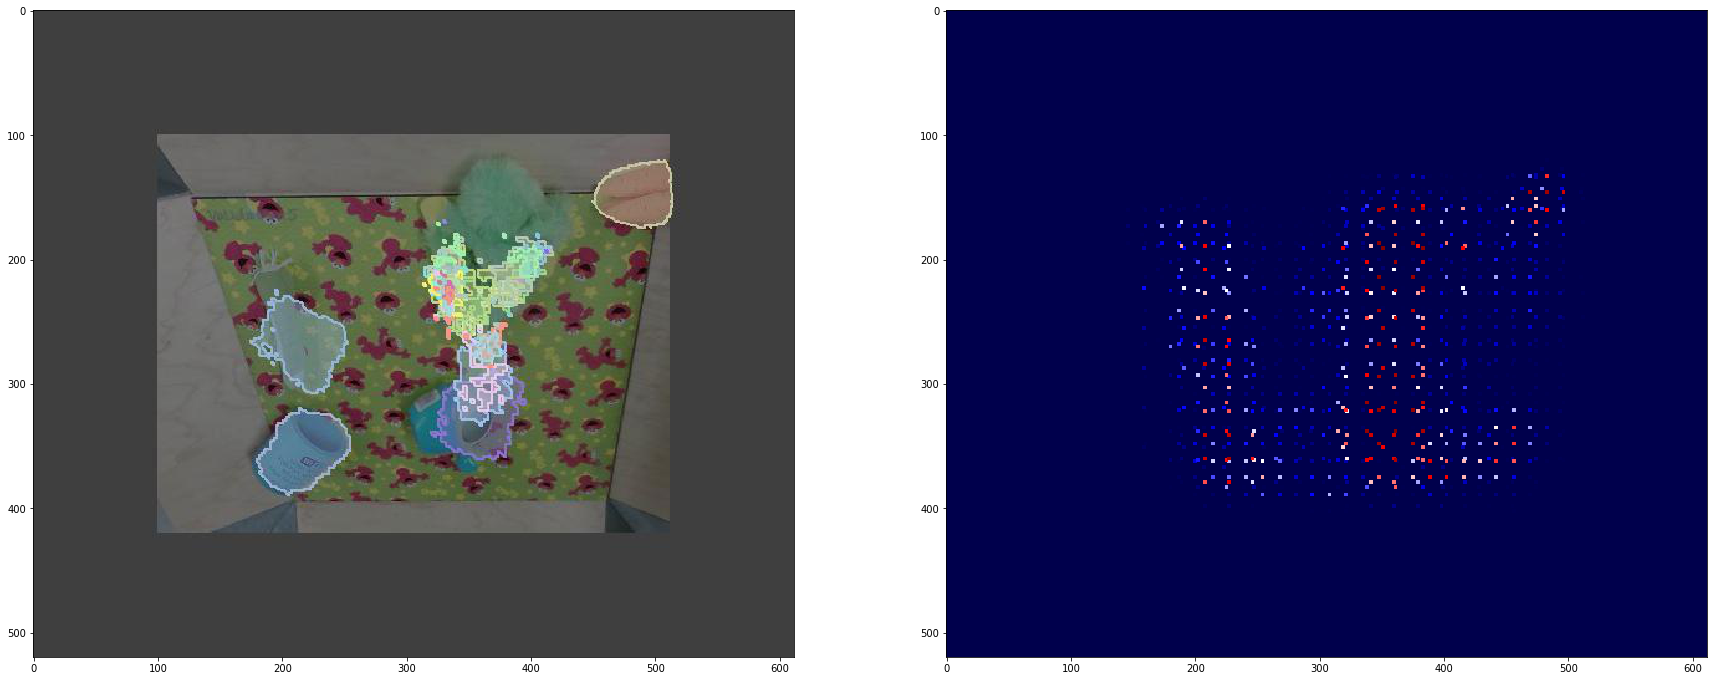

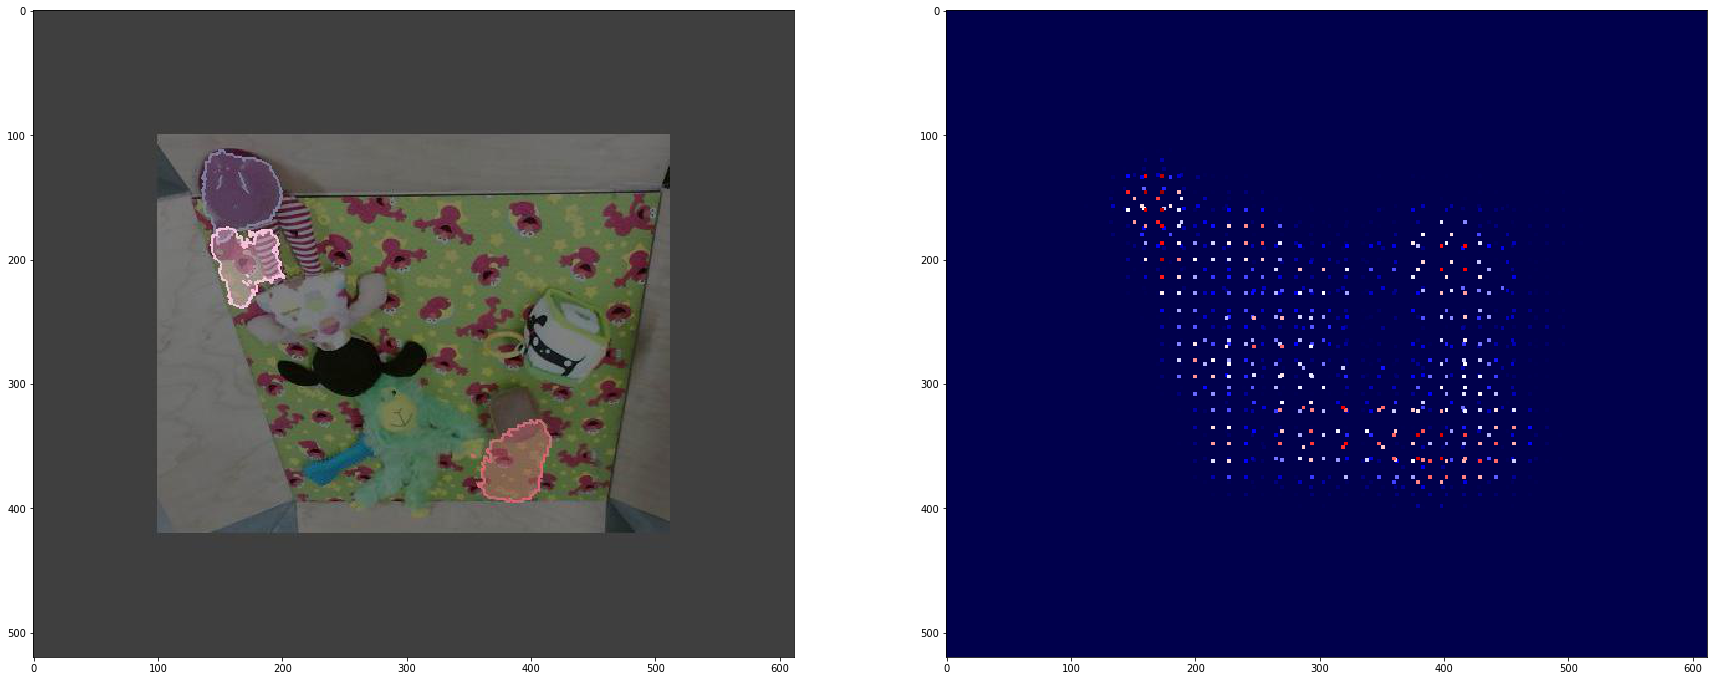

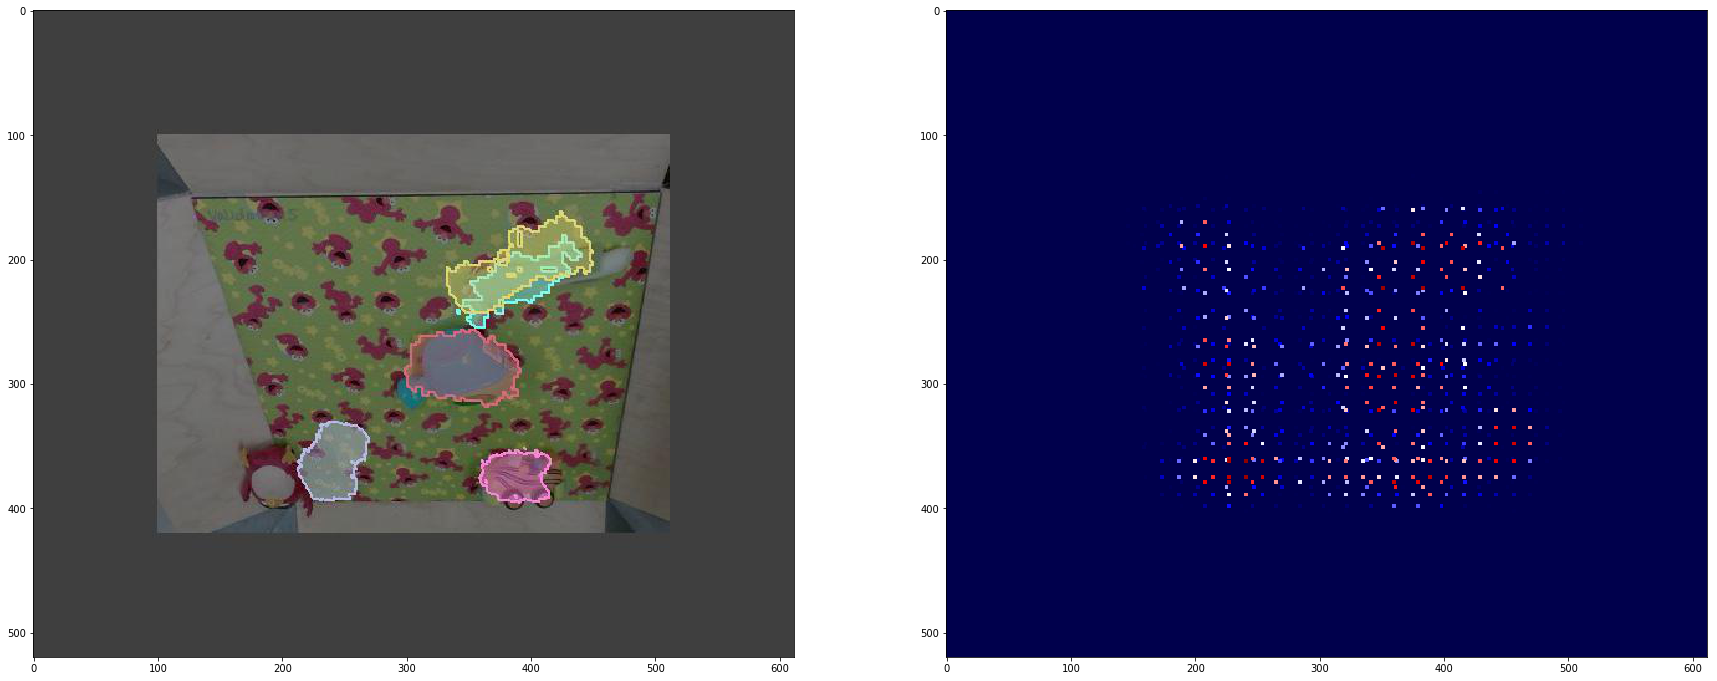

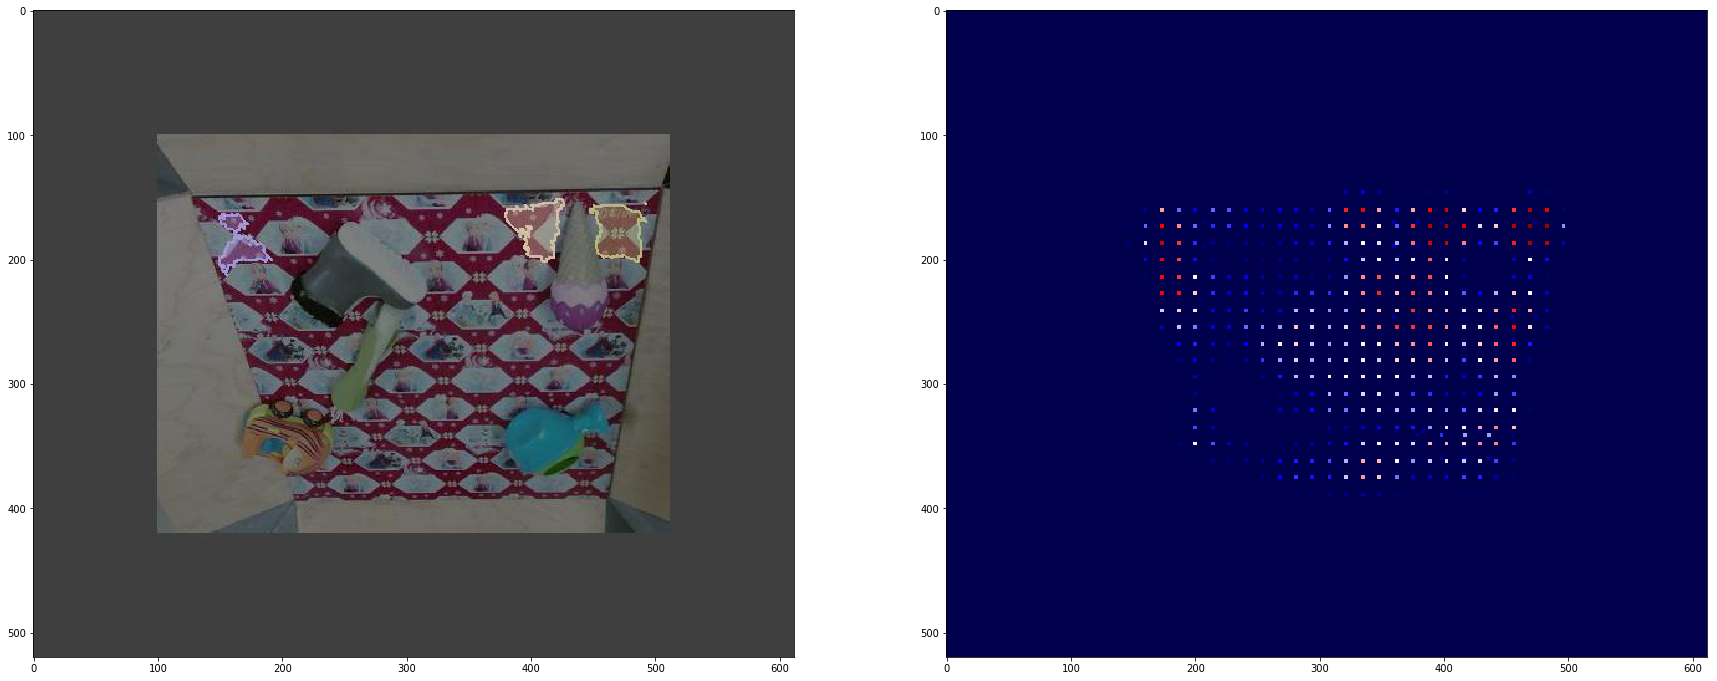

NameError: name 'fred' is not defined

In [4]:
count = 0

        
iou_list = []      
for i, img, mask, dp_msk_im, dp_msk_msk in zip(range(len(imgs)), imgs, masks,deep_mask_imgs, deep_mask_masks):
    
    img = img[:320, :412,:]
    mask = mask[:320, :412]
    img = np.lib.pad(img, ([100,100],[100,100],[0,0]), 'constant', constant_values=127)
    result = reference.compute_multi_scale_slicing_window(img, msk_thr = 0.6)
    score_cut_NMS = reference.msk_cut_score_NMS(score_tr = 0.85, firstn = 10)
    
    #iou scores
    iou_list.append(iou_help(mask, score_cut_NMS))

    coco_result = coco_API_plot(img, score_cut_NMS)
    f, (ax1, ax2) = plt.subplots(1,2, figsize = (30,30))
    ax1.imshow(coco_result)
    score_map = reference.score_heatmap()
    score_map[0,0] = 1
    
#     import pdb; pdb.set_trace()
    ax2.imshow((score_map*255).astype(np.uint8), cmap = 'seismic',interpolation='nearest')
    plt.show()
#     for r in result[-10:]:
#         f, (ax1, ax2) = plt.subplots(1,2)
#         ax1.imshow(r.mask)
#         ax2.imshow(r.canonical_window)
#         ax2.set_title(r.score)
#         plt.show()
    count += 1
    if count == 20:
        fred()

iou_list = np.array(iou_list)
print("average_iout {}".format(np.mean(iou_list)))

In [ ]:

count = 0

        
iou_list = []      
for i, img, mask, dp_msk_im, dp_msk_msk in zip(range(len(imgs)), imgs, masks,deep_mask_imgs, deep_mask_masks):
    
    img = img[:320, :412,:]
    mask = mask[:320, :412]
    img = np.lib.pad(img, ([100,100],[100,100],[0,0]), 'constant', constant_values=127)
    result = reference.compute_multiscale_masks(img, msk_thr = 0.9)
    score_cut_NMS = reference.msk_cut_score_NMS(score_tr = 0.5)
    
    #iou scores
    iou_list.append(iou_help(mask, score_cut_NMS))

    coco_result = coco_API_plot(img, score_cut_NMS)
    f, (ax1, ax2) = plt.subplots(1,2, figsize = (30,30))
    ax1.imshow(coco_result)
    score_map = reference.score_heatmap()
    score_map[0,0] = 1
#     import pdb; pdb.set_trace()
    ax2.imshow((score_map*255).astype(np.uint8), cmap = 'seismic',interpolation='nearest')
    plt.show()
#     for r in result[-50:]:
#         f, (ax1, ax2) = plt.subplots(1,2)
#         ax1.imshow(r.mask)
#         ax2.imshow(r.canonical_window)
#         ax2.set_title(r.score)
#         plt.show()
#     count += 1
#     if count == 20:
#         fred()

iou_list = np.array(iou_list)
print("average_iout {}".format(np.mean(iou_list)))


In [ ]:
reference.destory_graph()